# **🎯 You have to predict whether the user (student) will be able to successfully complete an online (university) course.**

# **Data description:**

**events_train.csv -** data on actions performed by students with steps

* **step_id** - step id
* **user_id -** anonymized user id
* **timestamp -** time of occurrence of the event in unix date format
* **action -** event, possible values:
    * **discovered -** the user switched to step
    * **viewed -** view step,
    * **started_attempt -** the beginning of an attempt to solve a step
    * **passed -** a good solution to a practical step


**submissions_train.csv -** data on the time and status of submissions for practical tasks

* **step_id -** step ID
* **timestamp -** time of sending the solution in unix date format
* **submission_status -** decision status
* **user_id -** anonymized user id

# **Import Libraries and Datasets**

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
events_df = pd.read_csv('/kaggle/input/predict-students-drop-out-of-the-course/event_data_train.csv')

subs_df = pd.read_csv('/kaggle/input/predict-students-drop-out-of-the-course/submissions_data_train.csv')


---

# **Data Pre-Processing**

* **Handling NULL Values in the Datasets :**

In [7]:
events_df.isna().sum()

step_id      0
timestamp    0
action       0
user_id      0
dtype: int64

In [8]:
subs_df.isna().sum()

step_id              0
timestamp            0
submission_status    0
user_id              0
dtype: int64

* **Handling Duplicates in the Datasets :**

In [17]:
# Checking size of the dataset
print(events_df.shape)

print(events_df.duplicated().sum())

# Drop the Duplicates
events_df = events_df.drop_duplicates()

print(events_df.shape)

(3480703, 4)
2333
(3478370, 4)


In [18]:
# Checking size of the dataset
print(subs_df.shape)

print(subs_df.duplicated().sum())

# Drop the Duplicates
subs_df = subs_df.drop_duplicates()

print(subs_df.shape)

(509104, 4)
107
(508997, 4)


* **Get overall information of the Datasets :**

In [19]:
events_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3478370 entries, 0 to 3480702
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   step_id    int64 
 1   timestamp  int64 
 2   action     object
 3   user_id    int64 
dtypes: int64(3), object(1)
memory usage: 132.7+ MB


In [20]:
subs_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 508997 entries, 0 to 509103
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   step_id            508997 non-null  int64 
 1   timestamp          508997 non-null  int64 
 2   submission_status  508997 non-null  object
 3   user_id            508997 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 19.4+ MB


* **Convert timestamp column to Date :**

In [31]:
subs_df['column_name'] = pd.to_datetime(subs_df['timestamp'], unit='s')

In [37]:
subs_df

,step_id,timestamp,submission_status,user_id
0,31971,2015-06-15 06:21:15,correct,15853
1,31972,2015-06-15 06:05:00,correct,15853
2,31972,2016-11-11 08:15:49,wrong,15853
3,31972,2016-11-11 08:16:04,correct,15853
4,31976,2015-06-15 06:02:03,wrong,15853
...,...,...,...,...
509099,120745,2017-08-05 15:29:19,wrong,2615
509100,120745,2017-08-18 12:38:47,correct,13177
509101,120745,2017-09-25 14:02:33,wrong,15253
509102,120745,2018-04-06 17:21:56,wrong,1424


In [33]:
events_df['timestamp'] = pd.to_datetime(events_df['timestamp'], unit='s')

In [38]:
events_df

,step_id,timestamp,action,user_id
0,32815,2015-06-15 04:00:48,viewed,17632
1,32815,2015-06-15 04:00:48,passed,17632
2,32815,2015-06-15 04:00:48,discovered,17632
3,32811,2015-06-15 04:01:35,discovered,17632
4,32811,2015-06-15 04:01:35,viewed,17632
...,...,...,...,...
3480698,33375,2018-05-19 23:31:25,viewed,11677
3480699,32815,2018-05-19 23:32:30,viewed,5198
3480700,32815,2018-05-19 23:32:30,discovered,5198
3480701,32815,2018-05-19 23:32:30,passed,5198


* **Handling Categorical Data :**

In [43]:
print(len(subs_df['step_id'].unique()))

print(len(subs_df['user_id'].unique()))

76
9940


In [44]:
print(len(events_df['step_id'].unique()))

print(len(events_df['user_id'].unique()))

198
19234


In [50]:
# Find number of unique use_id from both the datasets

print(len(set(events_df['user_id'].unique()) | set(subs_df['user_id'].unique())))

19234


In [45]:
subs_df['submission_status'].unique()

array(['correct', 'wrong'], dtype=object)

<Axes: xlabel='submission_status', ylabel='count'>

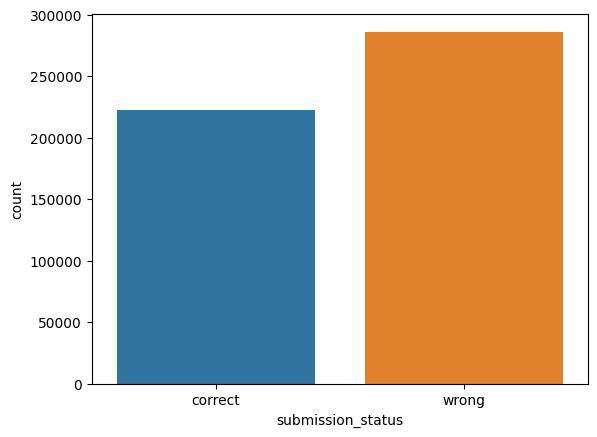

In [52]:
sns.countplot(x=subs_df['submission_status'])

In [54]:
# Encode Categorical Data
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
encoder = LabelEncoder()

# Fit and transform the data
subs_df['submission_status'] = encoder.fit_transform(subs_df['submission_status'])

subs_df['submission_status'].unique()

array([0, 1])

In [46]:
events_df['action'].unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

<Axes: xlabel='action', ylabel='count'>

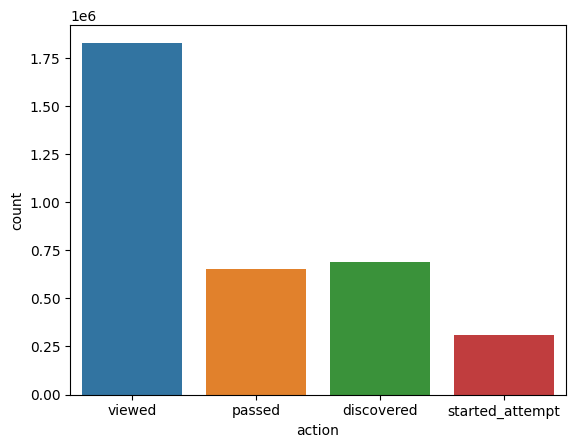

In [55]:
sns.countplot(x=events_df['action'])

In [56]:
# Fit and transform the data
events_df['action'] = encoder.fit_transform(events_df['action'])

events_df['action'].unique()

array([3, 1, 0, 2])

In [59]:
events_df

,step_id,timestamp,action,user_id
0,32815,2015-06-15 04:00:48,3,17632
1,32815,2015-06-15 04:00:48,1,17632
2,32815,2015-06-15 04:00:48,0,17632
3,32811,2015-06-15 04:01:35,0,17632
4,32811,2015-06-15 04:01:35,3,17632
...,...,...,...,...
3480698,33375,2018-05-19 23:31:25,3,11677
3480699,32815,2018-05-19 23:32:30,3,5198
3480700,32815,2018-05-19 23:32:30,0,5198
3480701,32815,2018-05-19 23:32:30,1,5198


In [60]:
subs_df

,step_id,timestamp,submission_status,user_id
0,31971,2015-06-15 06:21:15,0,15853
1,31972,2015-06-15 06:05:00,0,15853
2,31972,2016-11-11 08:15:49,1,15853
3,31972,2016-11-11 08:16:04,0,15853
4,31976,2015-06-15 06:02:03,1,15853
...,...,...,...,...
509099,120745,2017-08-05 15:29:19,1,2615
509100,120745,2017-08-18 12:38:47,0,13177
509101,120745,2017-09-25 14:02:33,1,15253
509102,120745,2018-04-06 17:21:56,1,1424
